In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt
from datamodules.aoj import AspenOpenJets 

aoj = AspenOpenJets(
    data_dir="/home/df630/Multimodal-Bridges/data/aoj", data_files="RunG_batch0.h5"
)

particle_set, _ = aoj(num_jets=10_000,
                      download=False,
                      features={"continuous": None, "discrete": "tokens"},
                      pt_order=True,
                      padding='zeros',
                      )

particle_set.mask = torch.ones_like(particle_set.discrete)


/home/df630/Multimodal-flows/multimodal_flows/datamodules/aoj.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_discrete_feats.append(torch.tensor(feats[features["discrete"]]))


In [10]:
particle_set.discrete[4]

tensor([[1],
        [2],
        [1],
        [1],
        [3],
        [3],
        [1],
        [1],
        [3],
        [2],
        [3],
        [4],
        [4],
        [1],
        [1],
        [1],
        [1],
        [4],
        [4],
        [4],
        [1],
        [3],
        [1],
        [3],
        [1],
        [1],
        [3],
        [1],
        [1],
        [4],
        [2],
        [4],
        [3],
        [4],
        [3],
        [3],
        [1],
        [1],
        [1],
        [3],
        [3],
        [3],
        [1],
        [1],
        [1],
        [3],
        [3],
        [1],
        [4],
        [3],
        [1],
        [4],
        [4],
        [4],
        [4],
        [1],
        [1],
        [4],
        [1],
        [3],
        [4],
        [4],
        [4],
        [3],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],

<Axes: ylabel='Density'>

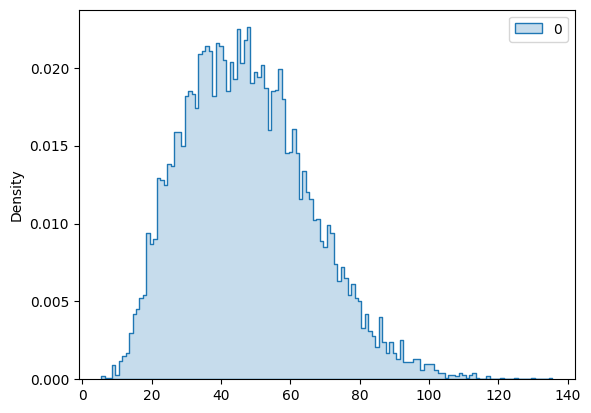

In [2]:
import seaborn as sns

sns.histplot((particle_set.discrete > 0).sum(dim=1), 
             discrete=True,
             stat="density",
             element="step",
             )

In [3]:
from torch.utils.data import DataLoader, random_split
from tensorclass import TensorMultiModal
from datamodules.datasets import MultiModalDataset, DataCoupling, data_coupling_collate_fn

data = DataCoupling(source=TensorMultiModal(), target=particle_set)
dataset = MultiModalDataset(data)
batch_size = 128

train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_coupling_collate_fn)
val_dataloader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, collate_fn=data_coupling_collate_fn)

In [12]:
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as L
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from scipy.special import gammaln, gamma, factorial

from transformers import GPT2LMHeadModel, GPT2Config

class JetGPT2Model(L.LightningModule):
    def __init__(
        self,
        max_seq_length: int = 150,
        n_embd=128,
        n_inner=None,
        n_layer=2,
        n_head=1,
        activation='gelu_new',
        dropout_att=0.1,
        dropout_emb=0.1,
        dropout_res=0.1,
        learning_rate=5e-4,
        learning_rate_final=0.0,
        top_k=None,
        temperature=1.0,
        pos_encoding=True,
    ):
        super().__init__()

        # basic config
        self.max_seq_length = max_seq_length    # real tokens per jet
        self.vocab_size = 8

        # model config
        self.lr = learning_rate
        self.lr_final = learning_rate_final
        self.do_sample = True  # sample multinomial
        self.temperature = temperature
        self.top_k = top_k
        self.pos_encoding = pos_encoding

        # special tokens:
        self.start_token = self.vocab_size + 1
        self.end_token = self.vocab_size + 2
        self.pad_token = 0   

        config = GPT2Config(
            vocab_size=self.vocab_size + 3,     # token vocab + BOS + EOS + pads
            n_positions=max_seq_length + 2,     # seq with BOS and EOS enpoints
            n_ctx=max_seq_length + 2,           # seq with BOS and EOS enpoints
            n_embd=n_embd,
            n_inner=n_inner if n_inner is not None else 4 * n_embd,
            n_layer=n_layer,
            n_head=n_head,
            activation_function=activation,
            attn_pdrop=dropout_att,
            embd_pdrop=dropout_emb,
            resid_pdrop=dropout_res,
            bos_token_id=self.start_token,
            eos_token_id=self.end_token,
            pad_token_id=self.pad_token,
        )

        self.model = GPT2LMHeadModel(config)

        if not self.pos_encoding:
            # If pos_encoding is disabled, zero & freeze GPT-2's pos embeddings
            with torch.no_grad():
                self.model.transformer.wpe.weight.zero_()
            self.model.transformer.wpe.weight.requires_grad = False

        self.save_hyperparameters()

    #...train/inference methods

    def forward(self, input_ids, attention_mask=None):

        outputs = self.model(input_ids=input_ids, 
                             attention_mask=attention_mask
                             )
        
        return outputs.logits

    def training_step(self, batch: TensorMultiModal, batch_idx):
        input_ids = batch.discrete.squeeze(-1).long(),
        mask = (self.input_ids != pad_token).long()
        outputs = self.model(input_ids=input_ids,
                             attention_mask=mask,
                             labels=self._mask_pads(input_ids),
                            )

        loss = outputs.loss
        self.log("train_loss",
                 loss,
                 on_epoch=True,
                 prog_bar=True,
                 logger=True,
                 sync_dist=True,
                 )

        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        input_ids = batch.discrete.squeeze(-1).long(),
        mask = (self.input_ids != pad_token).long()
        outputs = self.model(input_ids=input_ids,
                             attention_mask=mask,
                             labels=self._mask_pads(input_ids),
                            )

        loss = outputs.loss
        self.log("val_loss",
                 loss,
                 on_epoch=True,
                 prog_bar=True,
                 logger=True,
                 sync_dist=True,
                 )
        return {"val_loss": loss}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):


        preds = self.model.generate(
                        input_ids=batch,
                        max_new_tokens=self.max_seq_length + 2, 
                        do_sample=self.do_sample,
                        temperature=self.temperature,
                        top_k = self.top_k,
                        bos_token_id=self.start_token,
                        eos_token_id=self.end_token,
                        pad_token_id=self.pad_token,
                    )

        preds = F.pad(preds, (0, self.max_seq_length + 2 - preds.shape[1]), value=self.pad_token)

        return preds.detach().cpu()
 

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

        scheduler = CosineAnnealingLR(
            optimizer,
            T_max=self.trainer.max_epochs,    # full cycle length
            eta_min=self.lr_final             # final LR
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",   
                "frequency": 1,
                "strict": True,
            },
        }


    def _mask_pads(self, labels):
        """ Mask out the padding tokens in the labels.
        """
        labels = labels.clone()
        labels[labels == self.pad_token] = -100  # CE ignores
        return labels


In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt
from datamodules.aoj import AspenOpenJets 
from datamodules.utils import jet_set_to_seq

aoj = AspenOpenJets(
    data_dir="/home/df630/Multimodal-Bridges/data/aoj", data_files="RunG_batch0.h5"
)

num_jets = 30_000
max_num_particles = 150

particle_set, _ = aoj(num_jets=num_jets,
                      download=False,      
                      max_num_particles=max_num_particles,           
                      features={"continuous": None, "discrete": "tokens"},
                      pt_order=True,
                      padding='zeros',
                      )

particle_seq = jet_set_to_seq(particle_set, vocab_size=8)


/home/df630/Multimodal-flows/multimodal_flows/datamodules/aoj.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_discrete_feats.append(torch.tensor(feats[features["discrete"]]))


In [2]:
import torch
from pytorch_lightning.loggers import CometLogger
import pytorch_lightning as L
from torch.utils.data import DataLoader, random_split
from tensorclass import TensorMultiModal
from datamodules.datasets import MultiModalDataset, DataCoupling, data_coupling_collate_fn
from model.jetGPT import JetGPT2Model


experiment_id = '1515adfa207d4091814263a015ff80ba'
gpt = JetGPT2Model.load_from_checkpoint(f"/home/df630/Multimodal-flows/jet_sequences/{experiment_id}/checkpoints/best.ckpt", map_location="cpu",)


In [3]:
prompts = torch.full((num_jets, 1), gpt.start_token, dtype=torch.long)
attention_mask = torch.ones_like(prompts)

samples = gpt.model.generate(
                            input_ids=prompts,
                            attention_mask=attention_mask,
                            max_new_tokens=gpt.max_seq_length + 2, 
                            do_sample=True,
                            temperature=gpt.temperature,
                            top_k=gpt.top_k,
                            eos_token_id=gpt.end_token,
                            pad_token_id=gpt.pad_token,
                            )

In [28]:
samples.shape

torch.Size([30000, 142])

In [7]:
y = particle_seq.discrete.squeeze(-1).long()
(y==0).sum(),(y==1).sum(), (y==2).sum(),(y==3).sum(),(y==4).sum(),(y==5).sum(),(y==6).sum(),(y==7).sum(),(y==8).sum()

(tensor(0),
 tensor(449801),
 tensor(113845),
 tensor(423835),
 tensor(435271),
 tensor(2004),
 tensor(2073),
 tensor(1474),
 tensor(1389))

In [6]:
(samples==0).sum(),(samples==1).sum(), (samples==2).sum(), (samples==3).sum(), (samples==4).sum(), (samples==5).sum(), (samples==6).sum(), (samples==7).sum(), (samples==8).sum()

(tensor(0),
 tensor(455552),
 tensor(115491),
 tensor(428383),
 tensor(443855),
 tensor(2093),
 tensor(2070),
 tensor(1476),
 tensor(1412))

In [ ]:
generator = L.Trainer(accelerator="gpu", 
                      devices=[0], 
                      )

x = generator.predict(gpt, dataloaders=predict_dataloader)

In [4]:
X = torch.cat([xx.discrete for xx in x], dim=1).squeeze(-1).cpu()

In [12]:
X[1][0]

tensor([4, 1, 3, 4, 1, 2, 4, 4, 3, 1, 2, 2, 4, 2, 3, 4, 3, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])

In [13]:
X[1][0]

tensor([4, 1, 3, 4, 1, 2, 4, 4, 3, 1, 2, 2, 4, 2, 3, 4, 3, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])

In [10]:
samples[3]

tensor([ 9,  5,  1,  3,  4,  1,  4,  4,  4,  4,  3,  4,  3,  1,  1,  3,  3,  4,
         4,  3,  4,  1,  3,  4,  1,  4,  4,  1,  3,  1,  3,  1,  3,  1,  3,  1,
         3,  3,  4,  3,  1,  1,  4,  4, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])

<Axes: ylabel='Density'>

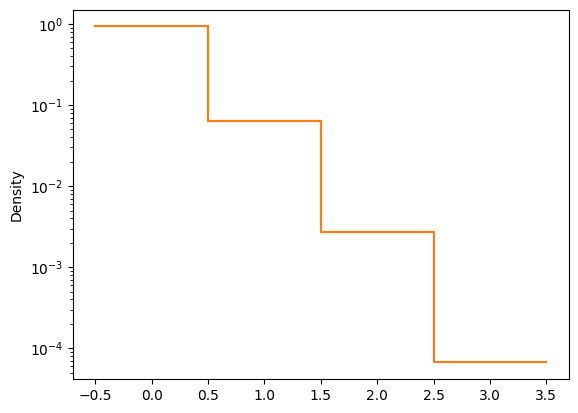

In [26]:
import seaborn as sns

n = 6

sns.histplot((particle_seq.discrete == n).sum(dim=1), 
             discrete=True,
             stat="density",
             element="step",
             fill=False,
              log_scale=(False, True),
             )


sns.histplot((samples == n).sum(dim=1),
                discrete=True,
                stat="density",
                element="step",
                fill=False,
                log_scale=(False, True),

                )

# sns.histplot((X[0] == n).sum(dim=1),
#                 discrete=True,
#                 stat="density",
#                 element="step",
#                 fill=False,
#                 log_scale=(False, True),
#                 )

<Axes: ylabel='Density'>

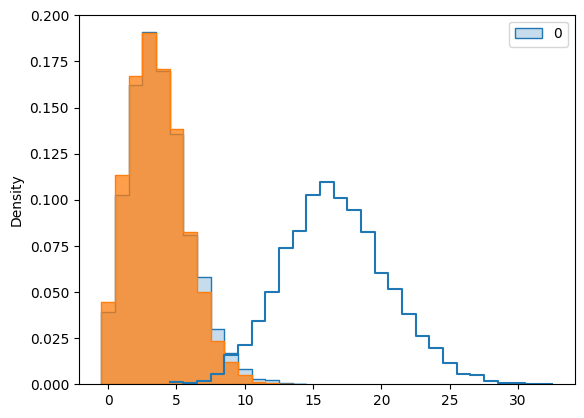

In [19]:
import seaborn as sns

n = 2

sns.histplot((particle_set.discrete == n).sum(dim=1), 
             discrete=True,
             stat="density",
             element="step",
             )


sns.histplot((X[1] == n).sum(dim=1),
                discrete=True,
                stat="density",
                element="step",
                )

sns.histplot((X[0] == n).sum(dim=1),
                discrete=True,
                stat="density",
                element="step",
                fill=False,
                )

In [20]:
X[1].flatten() == 0

array([ True, False, False, ..., False, False, False], shape=(150000,))

## Token ocurrence per jet

In [4]:
token_freqs = torch.tensor(
    [
        (data.isPhoton.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isNeutralHadron.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isNegativeHadron.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isPositiveHadron.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isElectron.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isPositron.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isMuon.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isAntiMuon.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
    ]
)

In [12]:
batch = next(iter(train_dataloader))
state = mjb.sample_bridges(batch).to(mjb.device)
target = batch.target.discrete.squeeze(-1).to(mjb.device)

# run one forward+loss
outputs = mjb.model(
    input_ids      = state.discrete.squeeze(-1).long(),
    attention_mask= state.mask.squeeze(-1).long(),
    labels         = target.long(),
)
print("✔ forward OK, loss=", outputs.loss.item())

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


✔ forward OK, loss= 2.0418574810028076


tensor([[ 0., 10.,  3.,  ...,  0.,  0.,  0.],
        [ 0., 13.,  1.,  ...,  0.,  0.,  1.],
        [ 0.,  3.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  9.,  1.,  ...,  0.,  1.,  0.],
        [ 0.,  6.,  1.,  ...,  0.,  1.,  0.],
        [ 0., 29.,  4.,  ...,  0.,  0.,  0.]])


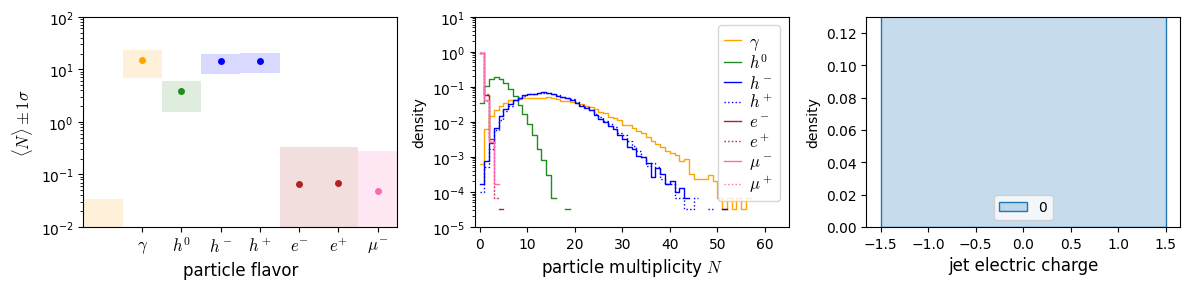

In [7]:
_, ax = plt.subplots(1, 3, figsize=(12, 3))

jets.plot_flavor_count_per_jet(
    markersize=8,
    color=[
        "orange",
        "orange",
        "forestgreen",
        "blue",
        "blue",
        "firebrick",
        "firebrick",
        "hotpink",
        "hotpink",
    ],
    ax=ax[0],
)

fill = False
alpha = 1 

data.histplot('num_Photon',ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100), binwidth=1,log_scale=(False, True),  stat='density', color='orange',lw=1,  label=r'$\gamma$')
data.histplot("num_NeutralHadron",  ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100), binwidth=1, log_scale=(False, True),  stat='density', color='forestgreen',lw=1,  label=r'$h^0$')
data.histplot("num_NegativeHadron", ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100), binwidth=1, log_scale=(False, True) , stat='density', color='blue', lw=1, label=r'$h^-$')
data.histplot("num_PositiveHadron",  ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100), binwidth=1, log_scale=(False, True), ls=':', stat='density', color='blue', lw=1, label=r'$h^+$')
data.histplot("num_Electron", ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100),binwidth=1, log_scale=(False, True),  stat='density', color='firebrick', lw=1,  label=r'$e^-$')
data.histplot("num_Positron", ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100),binwidth=1, log_scale=(False, True),  stat='density', color='firebrick', lw=1, ls=':', label=r'$e^+$')
data.histplot("num_Muon", ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100),binwidth=1, log_scale=(False, True),  stat='density', color='hotpink', lw=1, label=r'$\mu^-$')
data.histplot("num_AntiMuon", ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100),binwidth=1, log_scale=(False, True),  stat='density', color='hotpink', lw=1, ls=':', label=r'$\mu^+$')
data.histplot("charge", discrete=True, ax=ax[2], alpha=0.25, label="electric charge", stat='density', )

ax[0].set_xlim(-0.5,7.5)
ax[0].set_ylim(0.01,100)
ax[1].set_ylim(1e-5,10)
ax[1].set_xlim(-1,65)
ax[2].set_ylim(0.0,0.13)

ax[0].set_xlabel('particle flavor', fontsize=12)
ax[1].set_xlabel('particle multiplicity $N$', fontsize=12)
ax[1].set_ylabel('density', fontsize=10)
ax[2].set_xlabel('jet electric charge', fontsize=12)
ax[2].set_ylabel('density', fontsize=10)
ax[1].legend(fontsize=12, loc="upper right", handletextpad=0.5, handlelength=1., labelspacing=0.1)

plt.tight_layout()
plt.savefig("particle_discrete_feats.png", dpi=1000)


plt.show()



In [ ]:
sets.histplot("num_Photon", fill=False, discrete=True,  stat='density', color='blue', lw=1, label=r'$p_T$')

In [ ]:
particle_sets.histplot("numElectrons", discrete=True,  stat='density', color='blue', lw=1, label=r'$p_T$')

In [ ]:
import numpy as np
import torch

import matplotlib.pyplot as plt
from datamodules.aoj import AspenOpenJets

aoj = AspenOpenJets(
    data_dir="/home/df630/Multimodal-Bridges/data/aoj", data_files="RunG_batch0.h5"
)

particle_set, _ = aoj(
    num_jets=10_000,
    download=False,
    features={"continuous":None, "discrete": "tokens"},
)
